# 2D example. 

The operator is assume to be separable: $\phi(x,y) = \phi_1(x)\phi_2(y)$. Recover $\mu$ from 
$$
\int \phi(x,y) d\mu(x,y)
$$

In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import time

import mmd as mmd
import operators as myops
import lasso as ls
import continuous_BP as cbp
from helper import prune, generate_plots
from mmd import mmd_laplace as error_fun
from importlib import reload  # Python 3.4+
from numpy import linspace

reload(ls)
reload(myops)
reload(mmd)

def makeplot(x,E,color,legend=''):
    mean_curve = np.mean(E, axis=1)
    std_curve = np.std(E, axis=1)
    lower_bound = mean_curve - 1 * std_curve
    upper_bound = mean_curve + 1 * std_curve
    plt.plot(x, mean_curve, color=color,label=legend)
    plt.fill_between(x, lower_bound, upper_bound, color=color, alpha=0.2)


Define discretized operators

In [2]:
#define SR Lasso solver

nx= [20,5] #grid sizes

xgrid1 = linspace(0,1,nx[0])
xgrid2 = linspace(0,1,nx[1])

'''
#define Fourier
fq = 6
Phi,  A, dA = myops.getFourierMatrices(fq,xgrid1)

'''

#Define Gaussian
M = 20
tvec = np.linspace(0,1,M)
sigma=0.1
Phi, dPhi = myops.getGaussianOp(tvec,sigma)
A, dA = Phi(xgrid1), dPhi(xgrid1)

#define Laplace
T = 3
tvec = np.linspace(0,1,T)
Psi, dPsi = myops.getLaplaceOp(tvec)
B, dB  = Psi(xgrid2),dPsi(xgrid2)



#define SR Lasso with pruning
reload(cbp)
points = np.array([np.array([x,y]) for x in xgrid1 for y in xgrid2])
def SRLasso(y_obs,la,tau1,tau2,tol=1e-8):
    a,b1,b2 = cbp.SRLasso_2DTensor(A, dA, B, dB, y_obs,la,[tau1,tau2])
    grid = points+ np.stack((b1,b2),axis=1)
    a,grid = prune(a,grid,tol)  
    return a, grid




In [3]:
#define ground truth
h1 = xgrid1[1]-xgrid1[0]
h2 = xgrid2[1]-xgrid2[0]

spacing = np.array([0.4,0.4])
shift = np.array([[h1,-h2],[-h1,h2]])*spacing[None,:]
x_true = np.array( [ [xgrid1[nx[0]//4],xgrid2[nx[1]//8]], 
                    [xgrid1[3*nx[0]//4],xgrid2[nx[1]//2]] ]  ) + shift

a_true = np.array([1, 2])

y_true = np.einsum('kj,lj->kl', Phi(x_true[:,0]), Psi(x_true[:,1])*a_true[None,:]) 
noise_lev = 0.01*np.linalg.norm(y_true)/np.sqrt(len(y_true.reshape(-1)))



mydir = 'results/2D_tensor'
!mkdir $mydir

results_dir =  mydir+'/{s1}_{s2}'.format(s1=int(spacing[0]*100),
                                                    s2=int(spacing[1]*100))
!mkdir $results_dir
print(results_dir)

mkdir: results/2D_tensor: File exists
mkdir: results/2D_tensor/40_40: File exists
results/2D_tensor/40_40


error: 0.07439095732832252


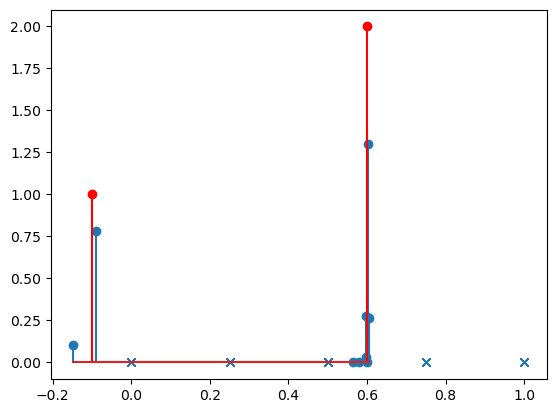

In [4]:
#test reconstruction
reload(ls)
y_obs = y_true + noise_lev*np.random.randn( *y_true.shape) 

la= .1
tau1,tau2= 1,1
a,grid = SRLasso(y_obs,la,tau1,tau2,tol=1e-4)

#plot one dimension
j=1
plt.stem(grid[:,j],np.abs(a))
plt.plot(points[:,j],points[:,j]*0,'x')
plt.stem(x_true[:,j], np.abs(a_true),'r')
print('error:', error_fun(grid,a,x_true, a_true))

In [5]:
#define Lasso solver

#forward and adjoint operators
def Op_lasso(A,B):
    Bt = B.T 
    Bc = B.conjugate()
    Act = A.conjugate().T
    
    def FWD(x):
        x0 = x[:,:,0]
        return (A@x0)@Bt
    
    def ADJ(x):
        z = (Act@x)@Bc
        return z[:,:,None]  
    return FWD, ADJ
FWD_lasso,ADJ_lasso = Op_lasso(A,B)

#Lasso on the grid
def Grid_Lasso(y_obs,la,tol=1e-8):
    x = ls.Lasso_Tensor(FWD_lasso,ADJ_lasso, y_obs,la)
    a,grid = prune(x.reshape(-1),points,tol)
    return grid, a



Run Lasso to find optimal $\lambda$ parameter

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


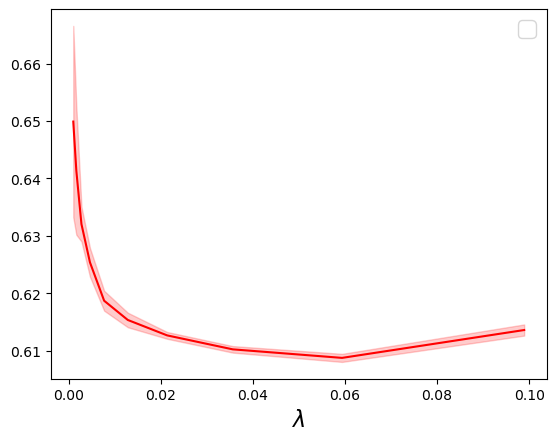

optimal lambda: 0.059368209421827606 error 0.6087483693320117


In [9]:
#grid search for optimal lambda
L=10
la_max = np.max(np.abs(A.conjugate().T@y_true@B.conjugate()))
la_vals = np.logspace(-3,np.log10(la_max/20),L)

Runs = 10
Res_Lasso = np.zeros((L,Runs))
for r in range(Runs):
    np.random.seed(1+r)
    y_obs = y_true + noise_lev*np.random.randn( *y_true.shape) 

    for i in range(L):
        la = la_vals[i]
        grid_lasso,al_val = Grid_Lasso(y_obs,la,1e-4)
        Res_Lasso[i,r] = error_fun(x_true, a_true,grid_lasso,al_val)

#display

'''
import matplotlib.pyplot as plt
makeplot(la_vals,Res_Lasso,'b',legend='')
plt.ylabel('Error', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)
plt.savefig(results_dir+'/lambda_Lasso.png', bbox_inches='tight', dpi=300)
plt.show()
'''

Plots = [Res_Lasso]
labels = ['']
generate_plots(Plots, labels, results_dir+'/lambda_Lasso.png',
                   xaxis=la_vals,xlabel='$\lambda$')

mean= np.mean(Res_Lasso, axis=1)
#retrieve optimal lambda
idx = np.where(mean==np.min(mean))[0][0]
la =la_vals[idx]
print('optimal lambda:' , la, 'error',np.min(mean))



Run SR Lasso for different $\tau$ parameters

In [12]:
#grid search for best tau1,tau2
K1 = 6
K2 = 5
tau_vals1 = np.linspace(0,1,K1)
tau_vals2 = np.linspace(0,1,K2)
Runs = 4
Res_SRLasso = np.zeros((K1,K2,Runs))
for r in range(Runs):   
    np.random.seed(1+r)
    y_obs = y_true + noise_lev*np.random.randn( y_true.shape[0],y_true.shape[1])

    for i in range(K1):
        for j in range(K2):
            tau1 = tau_vals1[i]
            tau2 = tau_vals2[j]
            a,grid = SRLasso(y_obs,la,tau1,tau2,1e-4)
            err = error_fun(grid,a,x_true,a_true)
            Res_SRLasso[i,j,r]=err
        
    print(r)
print(noise_lev)

0
1
2
3
0.002889910724467245


(6, 5, 4)


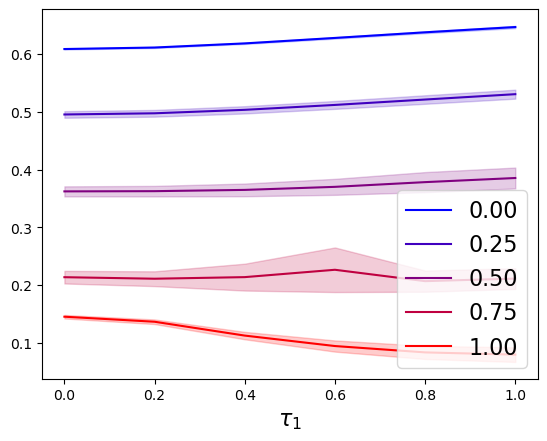

optimal params: 1.0 1.0


In [26]:
import matplotlib.pyplot as plt
import time
print(Res_SRLasso.shape)

Plots = [Res_SRLasso[:,i,:] for i in range(K2)]
labels = ['{tau:.2f}'.format(tau=tau_vals2[i]) for i in range(K2)]
generate_plots(Plots, labels, results_dir+'/tau1_SRLasso.png',
                   xaxis=tau_vals1,xlabel=r'$ \tau_1 $')


mean_curve= np.mean(Res_SRLasso,axis=2)

#find optimal tau
idx = np.where(mean_curve==np.min(mean_curve))
idx0,idx1=idx[0][0],idx[1][0]

tau1 = tau_vals1[idx0]
tau2 = tau_vals2[idx1]
print('optimal params:', tau1,tau2)



In [27]:
import random

#rerun both with same noise instance
y_obs = y_true + noise_lev*np.random.randn( y_true.shape[0],y_true.shape[1])
a,grid = SRLasso(y_obs,la,tau1,tau2,1e-4)
print('SR Lasso error',error_fun(x_true,a_true,grid,a))


grid_lasso,al_val = Grid_Lasso(y_obs,la,1e-4)

print('Lasso error',error_fun(x_true, a_true,grid_lasso,al_val))



SR Lasso error 0.07905062589122354
Lasso error 0.6081744059373346


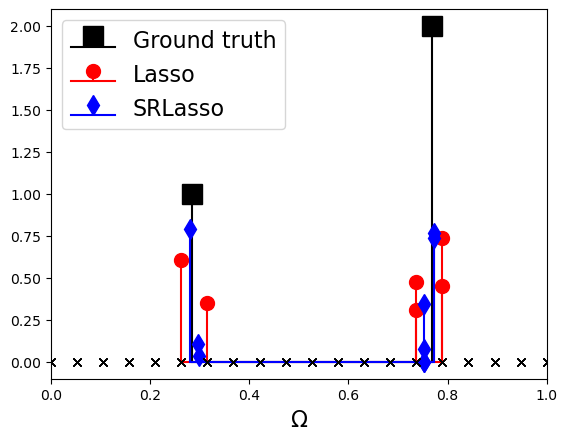

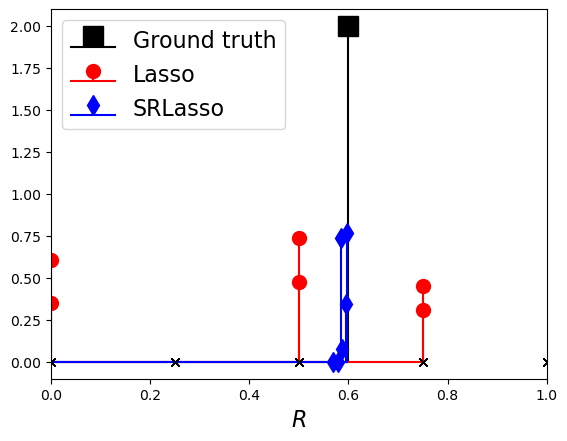

In [28]:


markerline, stemlines, baseline = plt.stem(x_true[:,0], np.abs(a_true),linefmt='k-',markerfmt='ks',basefmt='k-',label='Ground truth')
plt.setp(markerline,  markersize = 15)

markerline, stemlines, baseline = plt.stem(grid_lasso[:,0],np.abs(al_val),linefmt='r-',markerfmt='ro',basefmt='r-',label='Lasso')
plt.setp(markerline,  markersize = 10)
markerline, stemlines, baseline =  plt.stem(grid[:,0],np.abs(a),linefmt='b-', 
                                            markerfmt='bd',basefmt='b-',label='SRLasso')
plt.plot(points[:,0], 0*points[:,0],'kx')

plt.setp(markerline,  markersize = 10)
plt.xlim([0,1])

plt.legend( fontsize="16",loc='upper left')
plt.xlabel('$\Omega$',fontsize="16")

plt.savefig(results_dir+'/comparison_1.png', bbox_inches='tight')
plt.show()

plt.plot(points[:,1], 0*points[:,0],'kx')
markerline, stemlines, baseline = plt.stem(x_true[:,1], np.abs(a_true),linefmt='k-',markerfmt='ks',basefmt='k-',label='Ground truth')
plt.setp(markerline,  markersize = 15)

markerline, stemlines, baseline =plt.stem(grid_lasso[:,1],np.abs(al_val),linefmt='r-',markerfmt='ro',basefmt='r-',label='Lasso')
plt.setp(markerline,  markersize = 10)

markerline, stemlines, baseline = plt.stem(grid[:,1],np.abs(a),linefmt='b-',markerfmt='bd',basefmt='b-',label='SRLasso')
plt.plot(points[:,1], 0*points[:,0],'kx')

plt.setp(markerline,  markersize = 10)


plt.xlim([0,1])

plt.xlabel('$R$',fontsize="16")

plt.legend( fontsize="16",loc='upper left')

plt.savefig(results_dir+'/comparison_2.png', bbox_inches='tight')